In [66]:
from transformers import RobertaTokenizerFast, AutoModelForTokenClassification, AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, accuracy_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import pickle5 as pickle

In [67]:
import torch
torch.cuda.is_available()

True

In [68]:
OUTPUT_DIR = '../subset_outputs/custom_modified/'

In [69]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, path, num_classes, plddt = False):
        super(CustomBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(path)
        self.dropout = nn.Dropout(0.1)  # Adjust dropout rate as needed
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.plddt = plddt
        if plddt:
            self.fc = nn.Linear(self.bert.config.hidden_size + 1, num_classes)

    def forward(self, input_ids, attention_mask, plddts=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state
        if plddts is not None and self.plddt:
            pooled_output = torch.concat((pooled_output, plddts.unsqueeze(-1)), dim=2)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [70]:
PRETRAINED_MODEL = "../checkpoint-final/"
NUM_CLASSES=2
best_model_path = '../subset_outputs/custom_modified/best_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = RobertaTokenizerFast.from_pretrained("../checkpoint-final/")
best_ft_model = CustomBERTClassifier(PRETRAINED_MODEL, NUM_CLASSES, True)
best_ft_model.load_state_dict(torch.load(best_model_path))
best_ft_model.to(device)
df_test = pd.read_pickle('../Datasets/subset_test.pkl')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at ../checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
df_test

,disprot_ID,Sequence,full,pLDDT
448,DP02234,MPLLWLRGFLLASCWIIVRSSPTPGSEGHSAAPDCPSCALAALPKD...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.434, 0.599, 0.4575, 0.4856, 0.4719, 0.4548,..."
460,DP02292,MATGLGEPVYGLSEDEGESRILRVKVVSGIDLAKKDIFGASDPYVK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3243, 0.4252, 0.4764, 0.4484, 0.4965, 0.564..."
413,DP02129,MVLEATMILIDNSEWMINGDYIPTRFEAQKDTVHMIFNQKINDNPE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5988, 0.805, 0.8922, 0.8993, 0.927, 0.9265,..."
396,DP02055,MSKEDFVIKPEAAGASTDTSEWPLLLKNFDKLLVRSGHYTPIPAGS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.419, 0.4039, 0.4965, 0.6508, 0.7151, 0.8537..."
41,DP01165,MENSEKTEVVLLACGSFNPITNMHLRLFELAKDYMNGTGRYTVVKG...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4501, 0.4845, 0.5495, 0.6958, 0.8634, 0.937..."
300,DP01760,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.37, 0.3556, 0.3235, 0.3363, 0.3432, 0.3348,..."
231,DP01560,MATDSWALAVDEQEAAAESLSNLHLKEEKIKPDTNGAVVKTNANAE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.345, 0.4135, 0.3976, 0.4584, 0.6212, 0.3999..."
141,DP01404,MAAAIASSLIRQKRQAREREKSNACKCVSSPSKGKTSCDKNKLNVF...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5444, 0.5118, 0.5578, 0.5919, 0.5818, 0.579..."
330,DP01848,MLGLRPPLLALVGLLSLGCVLSQECTKFKVSSCRECIESGPGCTWC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3921, 0.3884, 0.3703, 0.4699, 0.439, 0.5135..."
189,DP01490,MAAASRSASGWALLLLVALWQQRAAGSGVFQLQLQEFINERGVLAS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4644, 0.4629, 0.4678, 0.4748, 0.4729, 0.467..."


In [72]:
def precision_recall_f1_roc_convolve(name, logits, labels, convolution):
    logits = [i[1] for i in logits]
    convolved = np.convolve(np.array(logits).flatten(), np.array(convolution / np.sum(convolution).flatten()), 'same')
    p = [(1 - i, i) for i in convolved]
    roc = [i[1] for i in p]
    p = np.argmax(p, axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, p)
    roc_auc = roc_auc_score(labels, roc)
    mcc = matthews_corrcoef(labels, p)
    return {
        f'precision_{name}':precision[1],
        f'recall_{name}':recall[1],
        f'f1_{name}':f1[1],
        f'roc_auc_{name}':roc_auc,
        f'MCC_{name}':mcc,
    }

def compute_metrics(logits, labels):
    logits = softmax(logits, axis=1)
    l = labels
#     l = []
#     for j, i in enumerate(labels):
#         l = l + list(i)
#     print(len(l), len(logits))
    lg2 = logits
    metrics = {}
    metrics.update(precision_recall_f1_roc_convolve('normal', lg2, l, [1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa5', lg2, l, [1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa9', lg2, l, [1,1,1,1,1,1,1]))
#     metrics.update(precision_recall_f1_roc_convolve('wa15', lg2, l, [1]*15))
#     metrics.update(precision_recall_f1_roc_convolve('linear5', lg2, l, [1,2,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear9', lg2, l, [1,2,3,4,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('linear15', lg2, l, [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad5', lg2, l, [1,3,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad9', lg2, l, [1,3,9,27,81,27,9,3,1]))
#     metrics.update(precision_recall_f1_roc_convolve('quad15', lg2, l, [1,3,9,27,81,243,729,2187,729,243,81,27,9,3,1]))
    
    return metrics

def model_out(encoded, plddts, model):
    """Given encoding, pass through model to get logits. Returns logits."""
    encoded.to(device)
    with torch.no_grad():
        output = model(**encoded, plddts=plddts)
    return output

def get_word_vector(sent, tokenizer, plddts, model):
    """Returns logits."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt", truncation=True, max_length=1024)
    print(encoded['input_ids'].shape)
    out = model_out(encoded, plddts, model)
    return out

In [73]:
device = torch.device('cuda')
best_ft_model.to(device)

CustomBERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(35, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [74]:
Xs = []
labs = []
for index, row in df_test.iterrows():
    seq = row['Sequence']
    plddts = torch.tensor([0.0] + row['pLDDT'][:min(1022, len(seq))] + [0.0]).unsqueeze(0).to(device)
    print(plddts.shape)
    lab = list(row['full'])
    word_embedding = get_word_vector(seq[:min(1024, len(seq))], tokenizer, plddts, best_ft_model)
    word_embedding = word_embedding[0]
    word_embedding = word_embedding[1:-1]
    word_embedding = word_embedding.cpu()
    word_embedding_full = np.squeeze(word_embedding.numpy())
#     print(word_embedding.shape)
    if len(seq) > 2044:
        for i in range(1022, len(seq) - 1022, 1022):
            plddts = torch.tensor([0.0] + row['pLDDT'][i:i+1022] + [0.0]).unsqueeze(0).to(device)
            word_embedding = get_word_vector(seq[i:i+1022], tokenizer, plddts, best_ft_model)
            word_embedding = word_embedding[0]
            word_embedding = word_embedding[1:-1]
            word_embedding = word_embedding.cpu()
            word_embedding = np.squeeze(word_embedding.numpy())
            word_embedding_full = np.concatenate([word_embedding_full, word_embedding], axis=0)
    if len(seq) > 1024:
        plddts = torch.tensor([0.0] + row['pLDDT'][len(seq) - 1022:len(seq)] + [0.0]).unsqueeze(0).to(device)
        word_embedding = get_word_vector(seq[len(seq) - 1022:len(seq)], tokenizer, plddts, best_ft_model)
        word_embedding = word_embedding[0]
        word_embedding = word_embedding[1:-1]
        word_embedding = word_embedding.cpu()
        word_embedding = np.squeeze(word_embedding.numpy())
        overlap_amount = 1022 - (len(seq) % 1022)
        overlap = word_embedding_full[(-1 * overlap_amount):]
        word_embedding_full[(-1 * overlap_amount):] = (overlap + word_embedding[:overlap_amount]) / 2
        end_chunk = word_embedding[overlap_amount:]
        word_embedding_full = np.concatenate([word_embedding_full, end_chunk], axis=0)
#     print(word_embedding_full.shape, len(seq))
    Xs.append(word_embedding_full)
    labs.append(lab[:len(seq)])
    
    

torch.Size([1, 428])
torch.Size([1, 428])
torch.Size([1, 977])
torch.Size([1, 977])
torch.Size([1, 245])
torch.Size([1, 245])
torch.Size([1, 485])
torch.Size([1, 485])
torch.Size([1, 281])
torch.Size([1, 281])
torch.Size([1, 569])
torch.Size([1, 569])
torch.Size([1, 481])
torch.Size([1, 481])
torch.Size([1, 247])
torch.Size([1, 247])
torch.Size([1, 771])
torch.Size([1, 771])
torch.Size([1, 687])
torch.Size([1, 687])
torch.Size([1, 497])
torch.Size([1, 497])
torch.Size([1, 321])
torch.Size([1, 321])
torch.Size([1, 679])
torch.Size([1, 679])
torch.Size([1, 381])
torch.Size([1, 381])
torch.Size([1, 328])
torch.Size([1, 328])
torch.Size([1, 427])
torch.Size([1, 427])
torch.Size([1, 180])
torch.Size([1, 180])
torch.Size([1, 664])
torch.Size([1, 664])
torch.Size([1, 621])
torch.Size([1, 621])
torch.Size([1, 352])
torch.Size([1, 352])
torch.Size([1, 80])
torch.Size([1, 80])
torch.Size([1, 97])
torch.Size([1, 97])
torch.Size([1, 82])
torch.Size([1, 82])
torch.Size([1, 218])
torch.Size([1, 218]

In [75]:
Xs = np.concatenate(Xs)
labs = np.concatenate(labs)
metrics = compute_metrics(Xs, labs)
metrics

{'precision_normal': 0.48036951501154734,
 'recall_normal': 0.3921357392943711,
 'f1_normal': 0.431791221826809,
 'roc_auc_normal': 0.7932871577408437,
 'MCC_normal': 0.33761626366508685}

In [76]:
# Load data (deserialize)
with open(f'{OUTPUT_DIR}losses.pkl', 'rb') as f:
    losses = pickle.load(f)

train_losses = losses['train']
val_losses = losses['val']

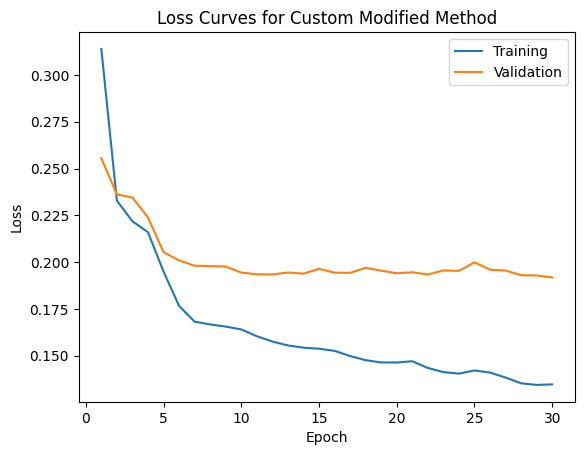

In [79]:
plt.plot(list(range(1, 31)), train_losses)
plt.plot(list(range(1, 31)), val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Curves for Custom Modified Method')
plt.legend(['Training', 'Validation'])
plt.show()


### Barplots showing results between baseline and modified

In [80]:
modified_results = {'precision_normal': 0.48036951501154734,
 'recall_normal': 0.3921357392943711,
 'f1_normal': 0.431791221826809,
 'roc_auc_normal': 0.7932871577408437,
 'MCC_normal': 0.33761626366508685}

In [81]:
baseline_results = {'precision_normal': 0.44892286309937457,
 'recall_normal': 0.34796660382440076,
 'f1_normal': 0.39204976483082987,
 'roc_auc_normal': 0.7892344235794801,
 'MCC_normal': 0.2954022547059736}

In [82]:
metrics_labels = ['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'MCC']
methods_labels = ['No pLDDT', 'pLDDT']

In [87]:
baseline_metrics = list(baseline_results.values())
modified_metrics = list(modified_results.values())

In [88]:
baseline_metrics

[0.44892286309937457,
 0.34796660382440076,
 0.39204976483082987,
 0.7892344235794801,
 0.2954022547059736]

In [83]:
# Set the width of the bars
bar_width = 0.35

# Set the positions of bars on X-axis
r1 = np.arange(len(metrics_labels))
r2 = [x + bar_width for x in r1]
print(r1)
print(r2)

[0 1 2 3 4]
[0.35, 1.35, 2.35, 3.35, 4.35]


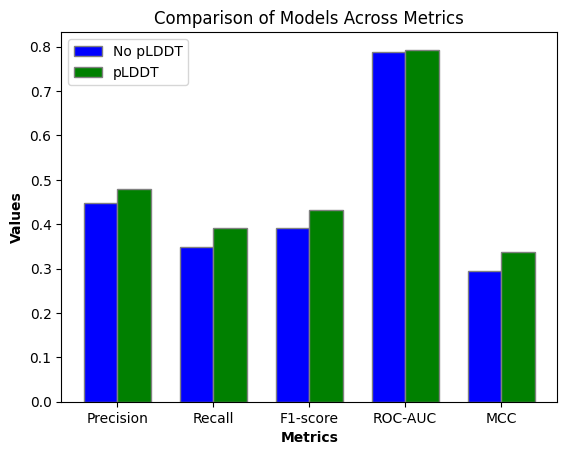

In [93]:
# Create bar plots
plt.bar(r1, baseline_metrics, color='b', width=bar_width, edgecolor='grey', label='No pLDDT')
plt.bar(r2, modified_metrics, color='g', width=bar_width, edgecolor='grey', label='pLDDT')
# Add labels, title, and legend
plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(metrics_labels))], metrics_labels)
plt.ylabel('Values', fontweight='bold')
plt.title('Comparison of Models Across Metrics')
plt.legend()

# Show the plot
plt.show()